In [39]:
import warnings

import aesara
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from aesara import tensor as at
from numpy.random import default_rng
from scipy.integrate import odeint

In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)
rng = default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89


def normalize(x):
    return (x - np.mean(x)) / np.std(x)

#### Code 16.1

In [3]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
# scale observed variables
d["w"] = d["weight"] / d["weight"].mean()
d["h"] = d["height"] / d["height"].mean()

#### Code 16.2

In [5]:
with pm.Model() as m16_1:
    sigma = pm.Exponential("sigma", 1)
    k = pm.Exponential("k", 0.5)
    p = pm.Beta("p", alpha=2, beta=18)
    mu = pm.Deterministic("mu", at.log(np.pi * k * at.pow(p, 2.0) * at.pow(d.h.values, 3.0)))
    w = pm.Lognormal("w", mu, sigma, observed=d.w.values)
    trace_16_1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, k, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


A prior predictive check is not done in the book, but it is alluded to: the author acknowledges that the priors could be improved, but the data will drive the posterior. So let's have a look at how bad these priors are.

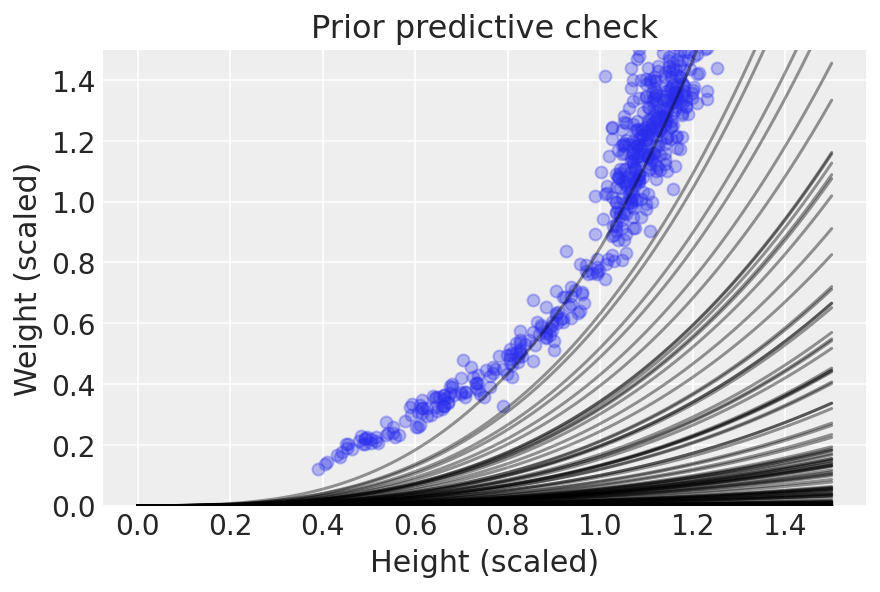

In [6]:
n_samples = 100
h_ppc = np.linspace(0, 1.5, n_samples)

with m16_1:
    prior_checks = pm.sample_prior_predictive(samples=n_samples)

k = np.array((prior_checks["prior"][["k"]]).to_array()).reshape(n_samples, 1)
p = np.array((prior_checks["prior"][["p"]]).to_array()).reshape(n_samples, 1)
w_ppc = np.dot(np.pi * k * p**2, h_ppc.reshape(1, 100) ** 3)

_, ax = plt.subplots()
for w in w_ppc:
    ax.plot(h_ppc, w, c="k", alpha=0.4)

ax.scatter(d.h, d.w, c="C0", alpha=0.3)
ax.set_ylim([0, 1.5])
ax.set_xlabel("Height (scaled)")
ax.set_ylabel("Weight (scaled)")
ax.set_title("Prior predictive check");

So clearly some refinement in the priors could be made (e.g. try $k \sim \rm{Exp}(0.25)$ and $p \sim \rm{Beta}(2, 5)$), but let's stick with the priors in the book.

In [7]:
with m16_1:
    trace_16_1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, k, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9012, but should be close to 0.8. Try to increase the number of tuning steps.


In [8]:
varnames = ["~mu"]
az.summary(trace_16_1, kind="stats", var_names=varnames)

,mean,sd,hdi_5.5%,hdi_94.5%
sigma,0.207,0.007,0.195,0.216
k,5.808,2.711,1.870,9.219
p,0.246,0.058,0.154,0.332


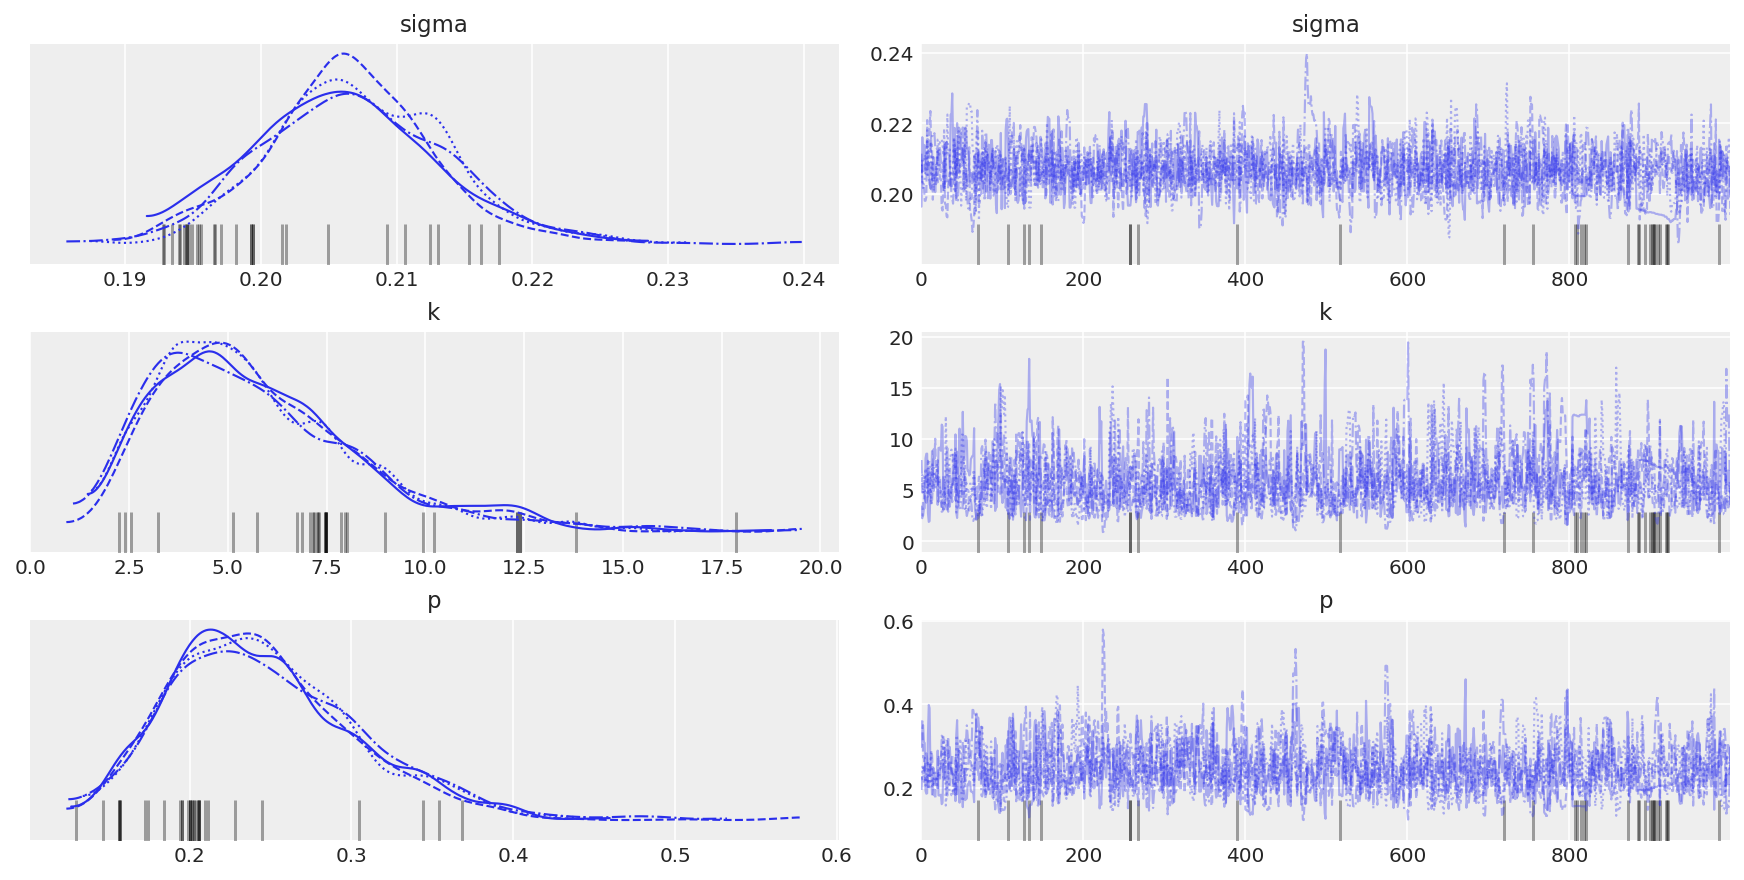

In [9]:
az.plot_trace(trace_16_1, varnames);

The divergences/warnings give us a clue that something in the model isn't working very well. The book explores this through the pairs plot of `k` and `p`

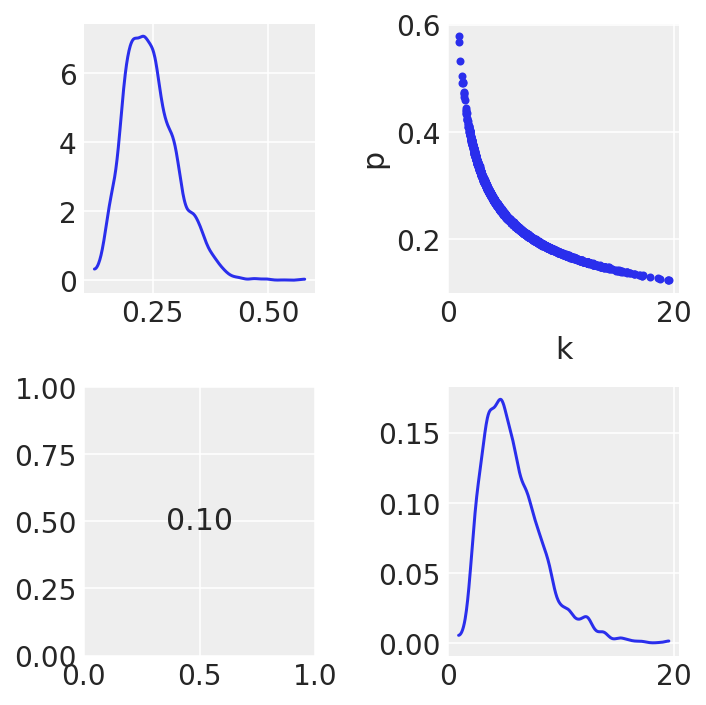

In [10]:
# Replicates Fig 16.2 (left) in the text
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5, 5))
az.plot_kde(np.array(trace_16_1["posterior"]["p"]), ax=ax1)
az.plot_pair(trace_16_1["posterior"], var_names=["k", "p"], kind="scatter", ax=ax2)
az.plot_kde(np.array(trace_16_1["posterior"]["k"]), ax=ax4)
corr = np.corrcoef(trace_16_1["posterior"]["p"], trace_16_1["posterior"]["k"])[0, 1]
ax3.text(
    0.5,
    0.5,
    f"{corr:.2f}",
    fontsize=15,
    verticalalignment="center",
    horizontalalignment="center",
)
plt.tight_layout();

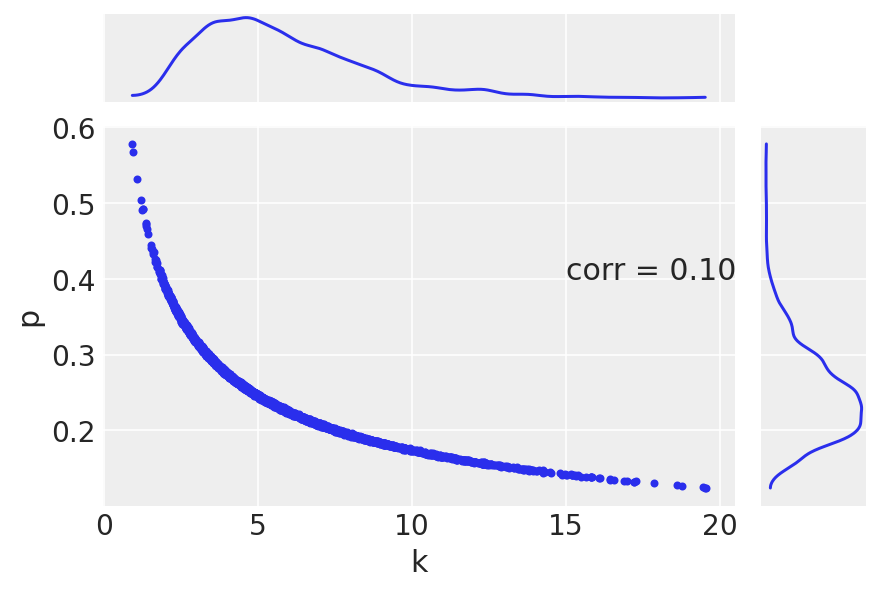

In [11]:
# A more native pymc/Arviz representation
axes = az.plot_pair(trace_16_1, var_names=["k", "p"], kind="scatter", marginals=True)
corr = np.corrcoef(trace_16_1["posterior"]["p"], trace_16_1["posterior"]["k"])[0, 1]
axes[1, 0].text(15, 0.4, f"corr = {corr:.2f}", fontsize=15);

The narrow curved ridge is caused by combinations of `p` and `k` where the product $kp^2$ is a constant.

#### Code 16.3

It is possible to draw the hpd for the entire range of `h_seq` below, by manually resampling the model from the Lognormal distribution, but here we are satisfied with the _Arviz_ hpd region which covers the range of the data.

In [12]:
with m16_1:
    w_sim = pm.sample_posterior_predictive(trace_16_1)["posterior_predictive"]["w"]
h_seq = np.linspace(0, d.h.max(), 30)
mu_mean = (
    np.array(np.pi * (trace_16_1["posterior"]["k"] * trace_16_1["posterior"]["p"] ** 2).mean())
    * h_seq**3
)

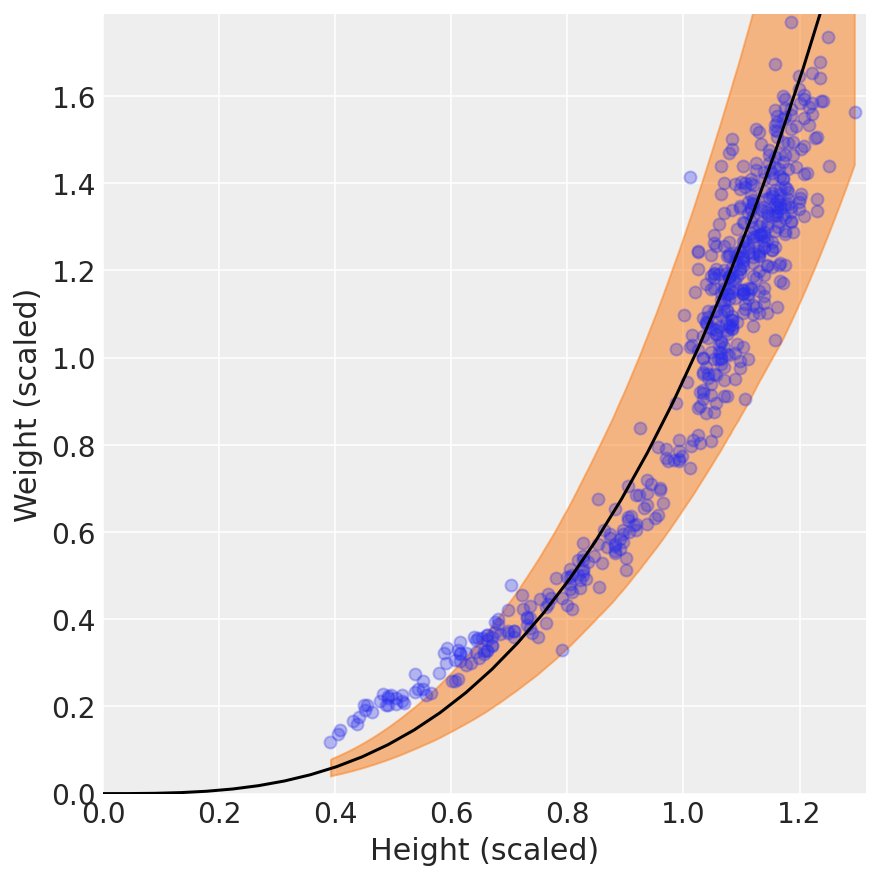

In [13]:
# Fig 16.2 (right) in the text
_, ax = plt.subplots(figsize=(6, 6))
az.plot_hdi(d.h.values, w_sim, ax=ax)
ax.scatter(d.h, d.w, c="C0", alpha=0.3)
ax.plot(h_seq, mu_mean, "k")
ax.set_xlim([0, d.h.max() + 0.02])
ax.set_ylim([0, d.w.max() + 0.02])
ax.set_xlabel("Height (scaled)")
ax.set_ylabel("Weight (scaled)");

Note there seems to be an error in Figure 16.2 of the book, as the axes limits are unit-scaled, whereas the mean of the data should appear at coordinates 1.0.

#### Code 16.4

In [14]:
df = pd.read_csv("Data/Boxes.csv", delimiter=";")
df.describe()

,y,gender,age,majority_first,culture
count,629.000000,629.000000,629.000000,629.000000,629.000000
mean,2.120827,1.505564,8.030207,0.484897,3.751987
std,0.727986,0.500367,2.497906,0.500170,1.960319
min,1.000000,1.000000,4.000000,0.000000,1.000000
25%,2.000000,1.000000,6.000000,0.000000,3.000000
50%,2.000000,2.000000,8.000000,0.000000,3.000000
75%,3.000000,2.000000,10.000000,1.000000,5.000000
max,3.000000,2.000000,14.000000,1.000000,8.000000


#### Code 16.5

In [15]:
df["y"].value_counts(normalize=True, sort=False)

1    0.211447
3    0.332273
2    0.456280
Name: y, dtype: float64

#### Code 16.6

In [16]:
N = 30  # number of children

# half are random
# sample from 1, 2, 3 at random for each
y1 = np.random.randint(low=1, high=4, size=N // 2)

y2 = np.full(shape=N // 2, fill_value=2)

y = np.random.permutation(np.hstack((y1, y2)))
np.sum(y == 2) / N

0.6333333333333333

#### Code 16.7

In [17]:
def StrategyMixture(p, majority_first):
    def logp(y):

        phi = [None] * 5

        # Probability of data
        phi[0] = at.switch(at.eq(y, 2), 1, 0)
        phi[1] = at.switch(at.eq(y, 3), 1, 0)
        phi[2] = at.switch(at.eq(y, 1), 1, 0)
        phi[3] = at.ones_like(y) * 1 / 3
        phi[4] = at.switch(
            at.eq(majority_first, 1), at.switch(at.eq(y, 2), 1, 0), at.switch(at.eq(y, 3), 1, 0)
        )

        # Compute log ( p_s * Pr(y_i|s) )
        for i in range(5):
            phi[i] = at.log(phi[i]) + at.log(p[i])

        # Compute average log-probability of y_i
        return at.sum(pm.math.logsumexp(phi, axis=0))

    return logp


with pm.Model() as m16_2:
    # prior
    p = pm.Dirichlet("p", np.array([4, 4, 4, 4, 4]))

    # likelihood
    y = pm.DensityDist(
        "y", logp=StrategyMixture(p, df["majority_first"].values), observed=df["y"].values
    )

In [18]:
def logp(value, p, majority_first):

    phi = [None] * 5

    # Probability of data
    phi[0] = at.switch(at.eq(value, 2), 1, 0)
    phi[1] = at.switch(at.eq(value, 3), 1, 0)
    phi[2] = at.switch(at.eq(value, 1), 1, 0)
    phi[3] = at.ones_like(value) * 1 / 3
    phi[4] = at.switch(
        at.eq(majority_first, 1), at.switch(at.eq(value, 2), 1, 0), at.switch(at.eq(value, 3), 1, 0)
    )

    # Compute log ( p_s * Pr(y_i|s) )
    for i in range(5):
        phi[i] = at.log(phi[i]) + at.log(p[i])

    # Compute average log-probability of y_i
    return at.sum(pm.math.logsumexp(phi, axis=0))


with pm.Model() as m16_2:
    # prior
    p = pm.Dirichlet("p", np.array([4, 4, 4, 4, 4]))

    # majority first data
    majority_first = pm.Data("majority_first", df["majority_first"].values)

    # likelihood
    y = pm.DensityDist("y", p, majority_first, logp=logp, observed=df["y"].values)

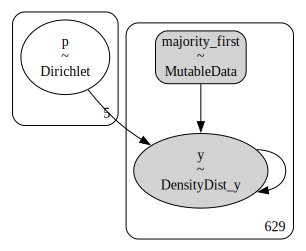

In [19]:
pm.model_to_graphviz(m16_2)

#### Code 16.8

In [20]:
with m16_2:
    m16_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


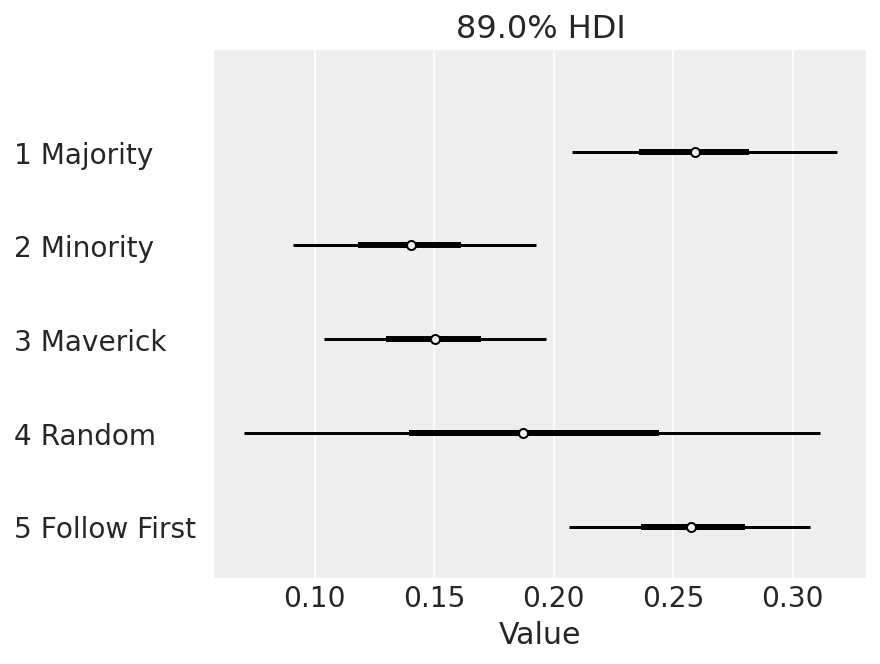

In [21]:
ax = az.plot_forest(m16_2_trace, combined=True, colors="black")

ax = ax[0]
ax.set_yticklabels(
    ["5 Follow First", "4 Random", "3 Maverick", "2 Minority", "1 Majority"], ha="left"
)
ax.get_yaxis().set_tick_params(pad=100)
ax.set_xlabel("Value");

#### Code 16.9

In [22]:
Panda_nuts = pd.read_csv("Data/Panda_nuts.csv", delimiter=";")
Panda_nuts.head()

,chimpanzee,age,sex,hammer,nuts_opened,seconds,help
0,11,3,m,G,0,61.0,N
1,11,3,m,G,0,37.0,N
2,18,4,f,wood,0,20.0,N
3,18,4,f,G,0,14.0,y
4,18,4,f,L,0,13.0,N


#### Code 16.10

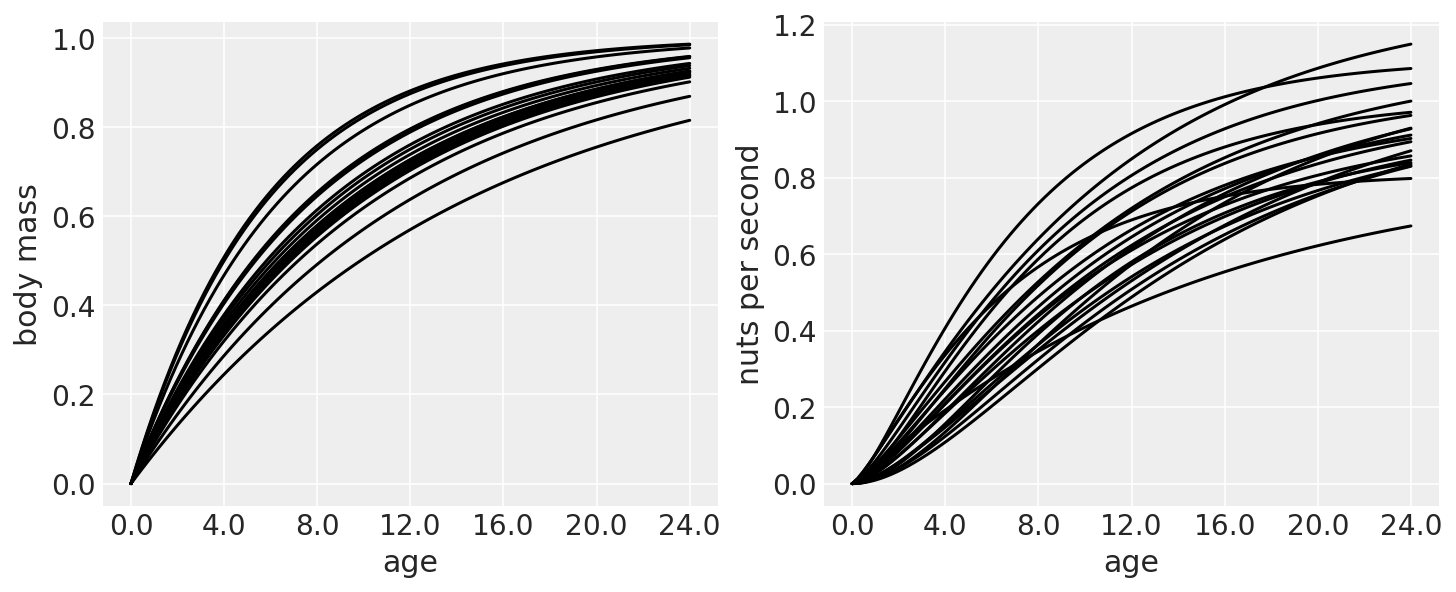

In [23]:
N = 10000
phi = np.random.lognormal(np.log(1), 0.1, N)
k = np.random.lognormal(np.log(2), 0.25, N)
theta = np.random.normal(np.log(5), 0.25, N)

# relative grow curve
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
x = np.linspace(0, 1.5, 100)
at = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
for i in range(20):
    ax[0].plot(x, 1 - np.exp(-k[i] * x), c="k")
ax[0].set_xticks(at, labels=at * np.max(Panda_nuts["age"].values))
ax[0].set_xlabel("age")
ax[0].set_ylabel("body mass")

# implied rate of nut opening curve
for i in range(20):
    ax[1].plot(x, phi[i] * (1 - np.exp(-k[i] * x)) ** theta[i], c="k")
ax[1].set_xticks(at, labels=at * np.max(Panda_nuts["age"].values))
ax[1].set_xlabel("age")
ax[1].set_ylabel("nuts per second");

#### Code 16.11

In [24]:
with pm.Model() as m16_4:

    # Data
    age = pm.Data("age", (Panda_nuts["age"] / np.max(Panda_nuts["age"])).values, mutable=False)
    seconds = pm.Data("seconds", Panda_nuts["seconds"].values, mutable=False)

    # Prios
    theta = pm.LogNormal("theta", np.log(5), 0.25)
    k = pm.LogNormal("k", np.log(2), 0.25)
    phi = pm.LogNormal("phi", np.log(1), 0.1)
    lam = pm.Deterministic("lam", seconds * phi * (1 - np.exp(-k * age)) ** theta)

    # Likelihood
    n = pm.Poisson("n", lam, observed=Panda_nuts["nuts_opened"].values)

    idata_16_4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, k, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.8846, but should be close to 0.8. Try to increase the number of tuning steps.


The book mentions that we should check the chain diagnostics. We will do that here.

In [25]:
az.summary(idata_16_4, var_names=["theta", "k", "phi"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,9.723,2.106,6.532,12.948,0.055,0.039,1431.0,1356.0,1.00
k,5.931,0.581,4.955,6.812,0.016,0.011,1355.0,1394.0,1.01
phi,0.867,0.041,0.803,0.935,0.001,0.001,1680.0,1524.0,1.00


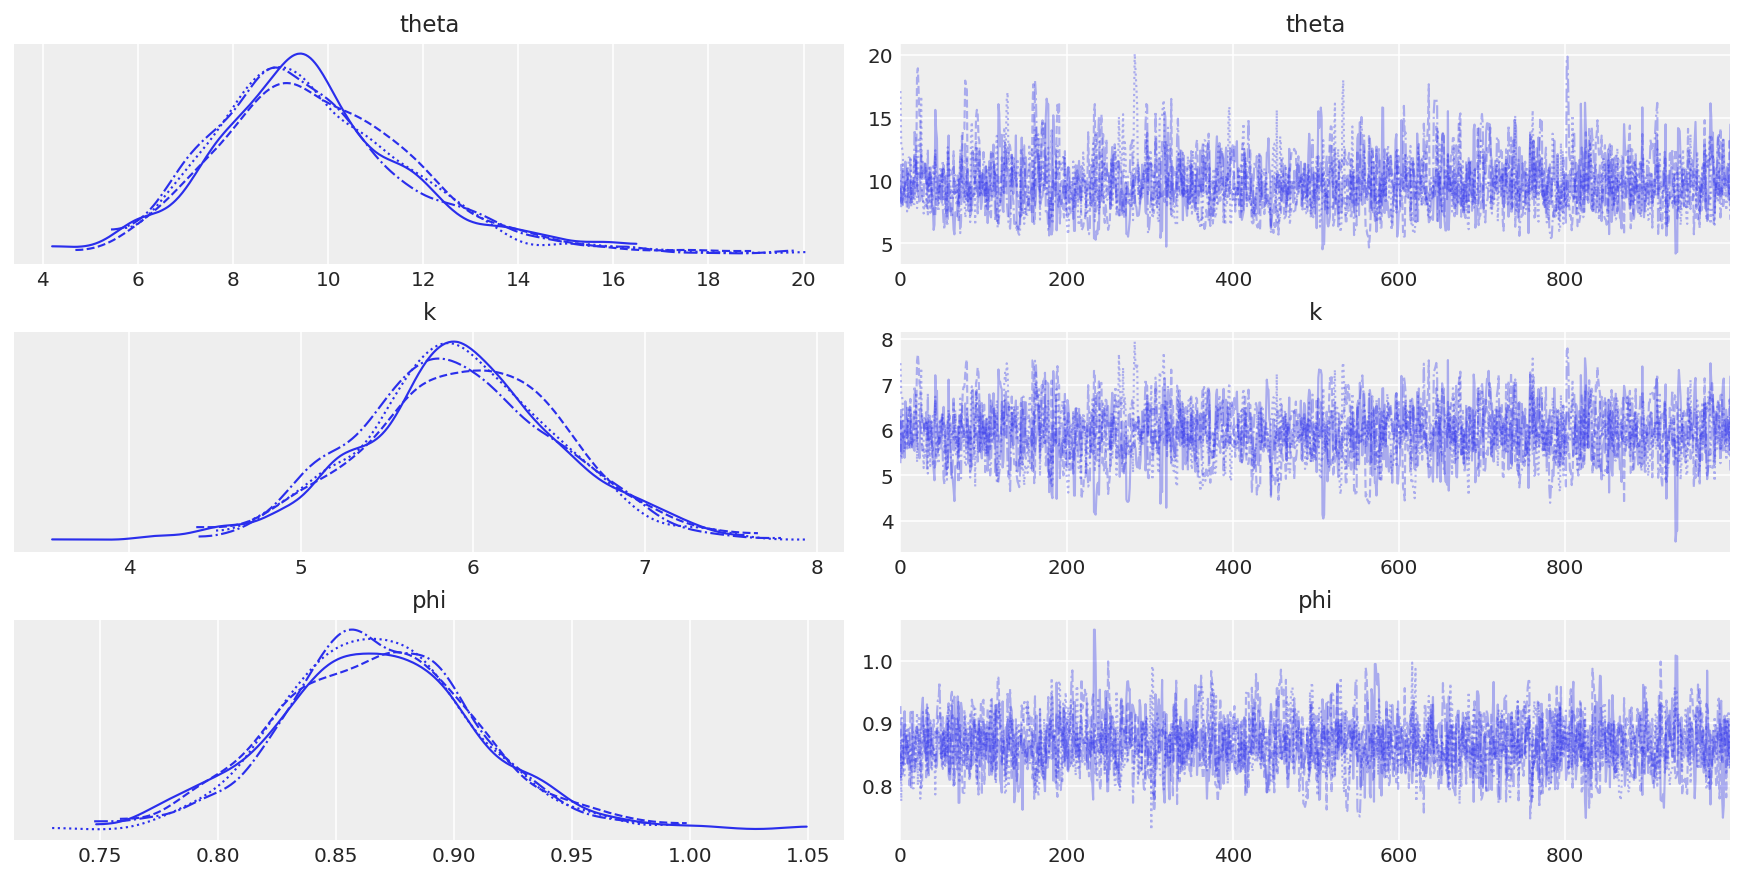

In [26]:
az.plot_trace(idata_16_4, var_names=["theta", "k", "phi"]);

#### Code 16.12

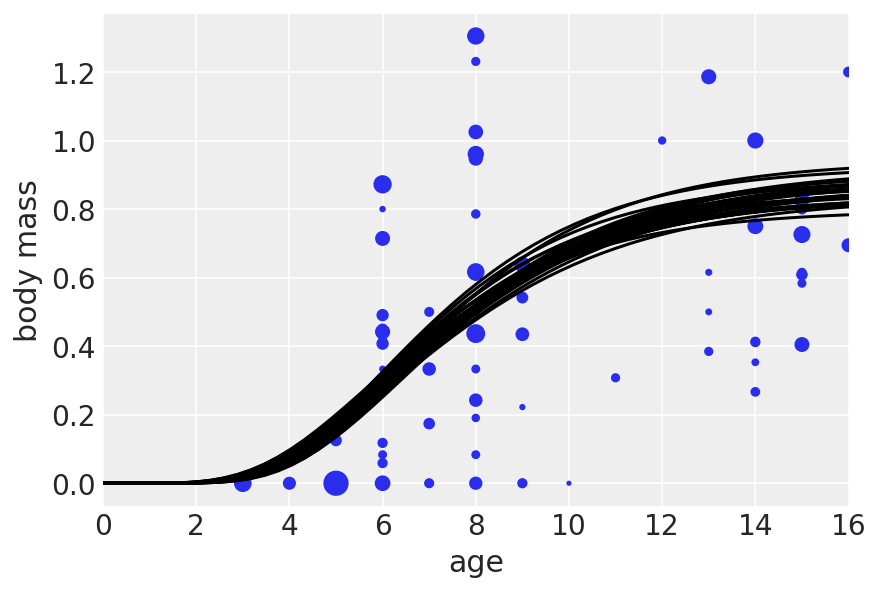

In [27]:
post = az.extract_dataset(idata_16_4["posterior"])

x = np.linspace(0, 1.5, Panda_nuts.shape[0])
at = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
plt.xlim(0, 16)
plt.xlabel("age")
plt.ylabel("body mass")

# raw data
pts = Panda_nuts["nuts_opened"] / Panda_nuts["seconds"]
point_size = Panda_nuts["seconds"]
plt.scatter(Panda_nuts["age"], pts, s=point_size)

# 30 posterior curves
for i in range(30):
    phi = np.array(post["phi"])
    k = np.array(post["k"])
    theta = np.array(post["theta"])
    plt.plot(x * np.max(Panda_nuts["age"]), phi[i] * (1 - np.exp(-k[i] * x)) ** theta[i], c="k");

#### Code 16.13

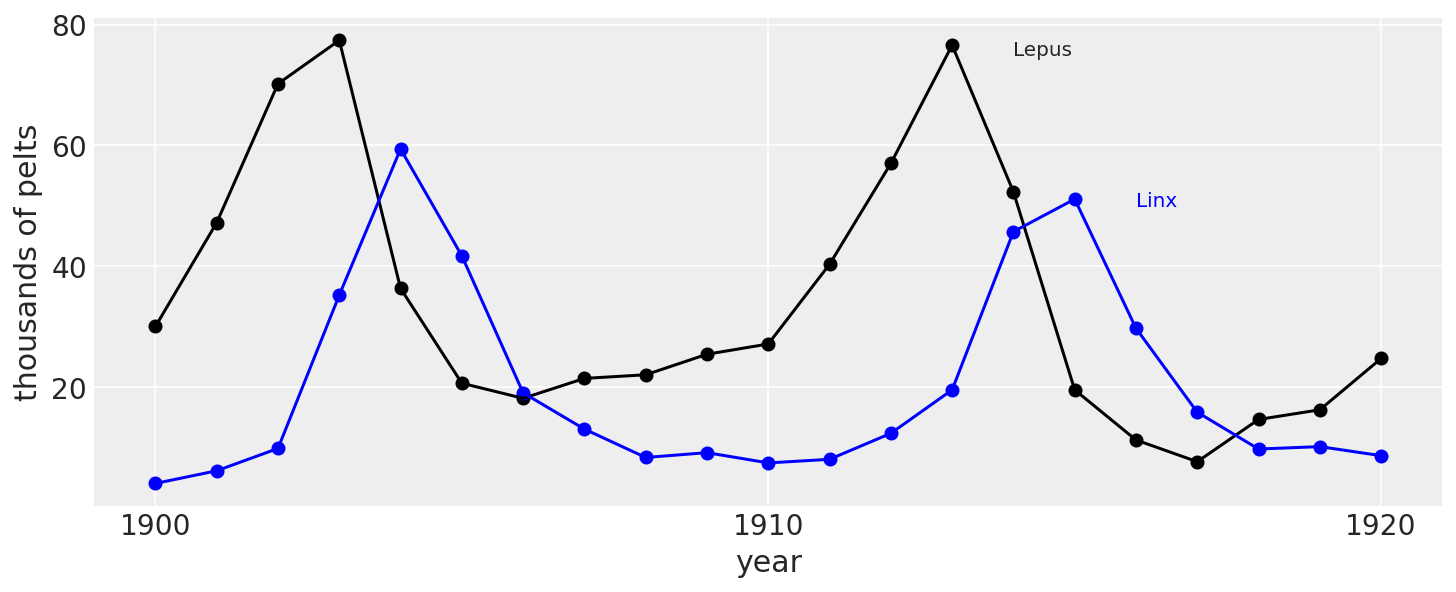

In [28]:
Lynx_Hare = pd.read_csv("Data/Lynx_Hare.csv", sep=";")
fig = plt.figure(figsize=(10, 4))
plt.plot(range(21), Lynx_Hare["Hare"], c="k")
plt.scatter(range(21), Lynx_Hare["Hare"], c="k")
plt.plot(range(21), Lynx_Hare["Lynx"], c="b")
plt.scatter(range(21), Lynx_Hare["Lynx"], c="b")
plt.xlabel("year")
plt.ylabel("thousands of pelts")


at = [0, 10, 20]
plt.xticks(at, labels=Lynx_Hare["Year"][at])

# text labels
plt.text(14, 75, "Lepus")
plt.text(16, 50, "Linx", c="b");

#### Code 16.14

In [29]:
def sim_lynx_hare(n_steps, init, theta, dt=0.002):
    L = [init[0]]
    H = [init[1]]
    for i in range(1, n_steps):
        H.append(H[-1] + dt * H[-1] * (theta[0] - theta[1] * L[-1]))
        L.append(L[-1] + dt * L[-1] * (theta[2] * H[-1] - theta[3]))

    return np.vstack([H, L]).T

#### Code 16.15

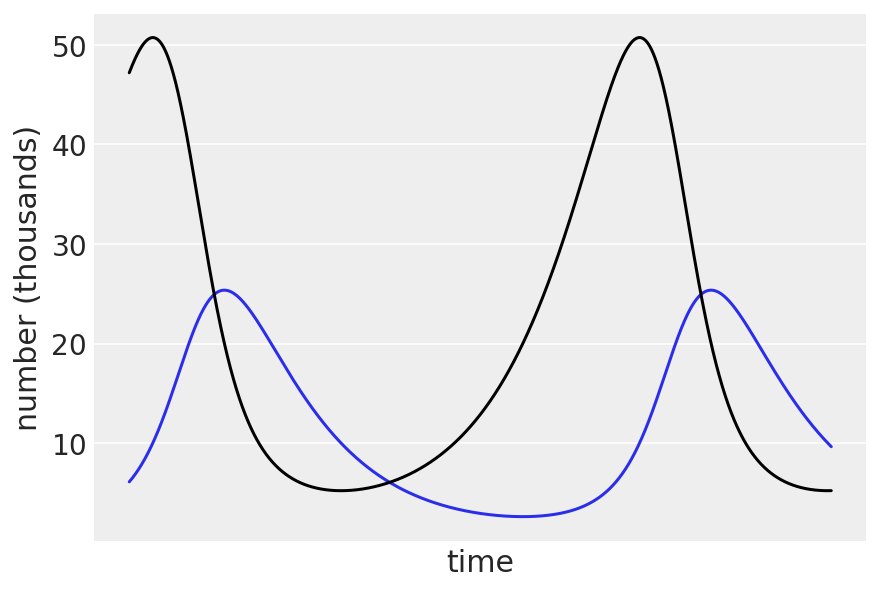

In [30]:
theta = [0.5, 0.05, 0.025, 0.5]
z = sim_lynx_hare(10000, Lynx_Hare.iloc[1, 1:3], theta)

plt.plot(z[:, 1])
plt.plot(z[:, 0], c="k")
plt.xticks([])
plt.xlabel("time")
plt.ylabel("number (thousands)");

#### Code 16.16

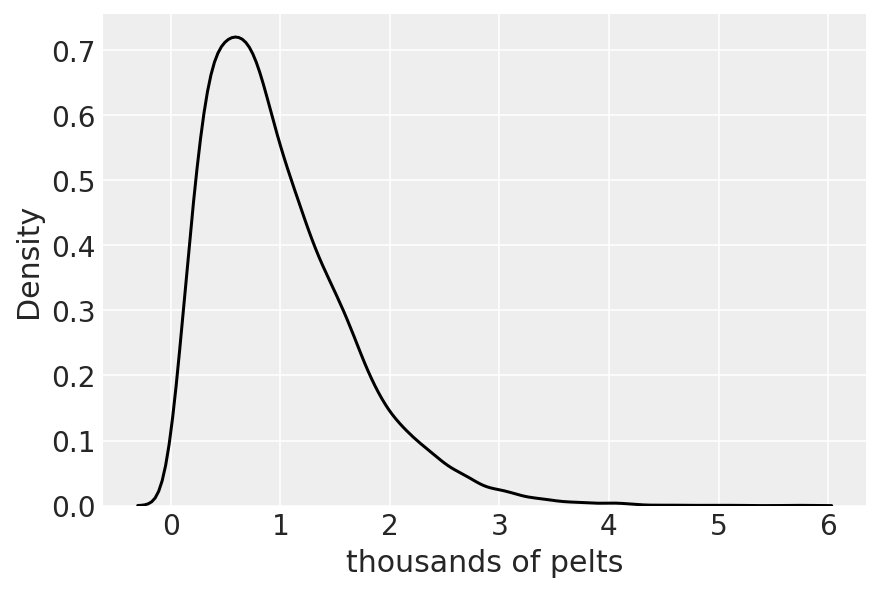

In [31]:
N = 10000
Ht = 10000
p = np.random.beta(2, 18, N)
h = np.random.binomial(N, p, Ht)
h = np.round(h / 1000, 2)

sns.kdeplot(h, c="k")
plt.xlabel("thousands of pelts");

#### Code 16.17 & 16.18

The book does not go into detail with respect to the model code. Building this model with pymc is fairly involved and requires some tricks, but it can be done. There is an [example](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_with_manual_gradients.html) on the PyMC site that can be referenced for building such a model.

The model code below is adopted from [this example](https://docs.pymc.io/en/v3/pymc-examples/examples/samplers/SMC-ABC_Lotka-Volterra_example.html) that leverages SMC (sequential monte carlo) and ABC (approximate bayesian computation). Unfortunately, I could not quite figure out how to integrate the population/pelt relationship in this model, so it is not quite the same as in the text. Any reader is encouraged to improve and update this code if a better solution is found.

In [40]:
from scipy.integrate import odeint

# initial pelt counts for Hare and Lynx
H_L0 = Lynx_Hare[["Hare", "Lynx"]].iloc[0, :]
# size of data
size = Lynx_Hare.shape[0]
# time
t = Lynx_Hare["Year"].values

# simulator function
def lynx_hare_simulator(rng, H_L0, b_H, m_H, b_L, m_L, size):
    """
    Returns a callable random simulator function for
    the Lynx-Hare model.

        Inputs:
            - rng: random number generator
            - H_L0: Initial values of Hare-Lynx pelts
            - b_H: birth rate for Hare
            - m_H: mortality rate for Hare
            - b_L: birth rate for Lynx
            - m_L: mortality rate for Lynx
            - size: size of output

        Output:
            - Scipy ODE int solver
    """
    # Lotka - Volterra equation
    def dX_dt(H_L, t, b_H, m_H, b_L, m_L):
        """Return the growth rate of fox and rabbit populations."""
        return np.array([H_L[0] * (b_H - m_H * H_L[1]), H_L[1] * (b_L * H_L[0] - m_L)])

    with warnings.catch_warnings():  # quite scipy warnings
        warnings.simplefilter("ignore")

        return odeint(dX_dt, y0=H_L0, t=t, rtol=0.01, args=(b_H, m_H, b_L, m_L))


observed = np.array(Lynx_Hare[["Hare", "Lynx"]])

In [41]:
with pm.Model() as Lynx_Hare_model:

    # Prior for Lotka-Volterra Parameters
    b_H = pm.HalfNormal("b_H", 1)
    b_L = pm.HalfNormal("b_L", 0.05)
    m_H = pm.HalfNormal("m_H", 0.05)
    m_L = pm.HalfNormal("m_L", 1)

    # Prior for measurement dispersion
    sigma_H = pm.Exponential("sigma_H", 1)
    sigma_L = pm.Exponential("sigma_L", 1)

    # Prior for initial hare-lynx pelts
    H_L0 = pm.LogNormal("H_L0", pm.math.log(10), 1, shape=2)

    # Model for Hare-Lynx Pelts
    H_L = pm.Simulator(
        "sim", lynx_hare_simulator, H_L0, b_H, m_H, b_L, m_L, epsilon=10, observed=observed
    )

    Lynx_Hare_idata = pm.sample_smc(kernel="ABC", chains=4, parallel=False)

Initializing SMC sampler...
Sampling 4 chains in 1 job


In [42]:
with Lynx_Hare_model:
    Lynx_Hare_ppd = pm.sample_posterior_predictive(Lynx_Hare_idata)

#### Code 16.19

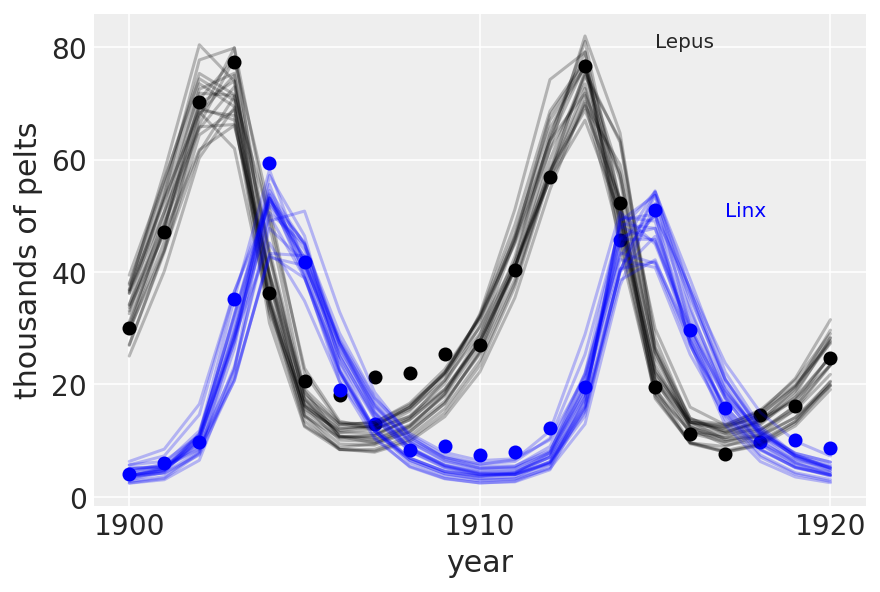

In [43]:
pelts = az.extract_dataset(Lynx_Hare_ppd["posterior_predictive"])["sim"]
n_pelts = 21  # number of pelt traces to plot
plt.scatter(range(21), Lynx_Hare["Hare"], c="k")
plt.scatter(range(21), Lynx_Hare["Lynx"], c="b")
plt.plot(pelts[:, 0, 0:n_pelts], c="k", alpha=0.25)
plt.plot(pelts[:, 1, 0:n_pelts], c="b", alpha=0.25)
at = [0, 10, 20]
plt.xticks(at, labels=Lynx_Hare["Year"][at])
plt.xlabel("year")
plt.ylabel("thousands of pelts")

# text labels
plt.text(15, 80, "Lepus")
plt.text(17, 50, "Linx", c="b");

In [44]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Nov 28 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

numpy     : 1.22.1
aesara    : 2.6.6
matplotlib: 3.5.2
seaborn   : 0.11.2
pandas    : 1.4.2
arviz     : 0.12.1
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC v.1929 64 bit (AMD64)]
pymc      : 4.0.0

Watermark: 2.3.1

